# Grib2の設定

In [1]:
from grib2_decoder import Visualize
from grib2_decoder import Loader
from grib2_decoder import FCST

In [2]:
lat = 34.70046472
lon = 135.49728256

file_name = "../etc/rainforecast/Z__C_RJTD_20180707115000_NOWC_GPV_Ggis0p25km_Pri60lv_Aper5min_FH0000-0030_grib2.bin"
wgrib2 = "../grib2//wgrib2/wgrib2"

In [3]:
decoder = Loader(wgrib2, file_name)
grid_info = decoder.get_grid(lat, lon, mag=1.0)

In [4]:
target_grid_info = grid_info[grid_info["fcst"] == FCST.ANL.value]
target_grid_info_10m = grid_info[grid_info["fcst"] == FCST.MIN_10.value]

In [5]:
rainfall = decoder.get_rainfall(target_grid_info["id"])

100%|██████████| 35/35 [00:10<00:00,  3.50it/s]


In [6]:
import numpy as np

rainfall_np = np.array(rainfall[rainfall["id"]=="1.4512"]["val"])
# rainfall_np = np.append(rainfall_np, 2.5)

In [7]:
rainfall_filter = []

for val in rainfall_np:
    if val<5:
        rainfall_filter.append(0)
    else:
        rainfall_filter.append(val)

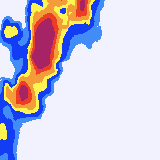

In [29]:
Visualize.to_image(160, rainfall_filter)

# 3*3マスへの対応

In [144]:
import numpy as np

def get_around_grids_info(grid_id: float, rainfall):
    offset_dic = {"UPPER_LEFT": -0.0035, "UPPER_RIGHT": -0.0033,
                  "CENTER":0, "RIGHT":0.0001, "LEFT": -0.0001,
                  "UNDER": 0.0034, "UP": -0.0034,
                  "UNDER_LEFT": 0.0033, "UNDER_RIGHT":0.0035} # 上下左右のgrid参照用のオフセット
    offset_list = ["UNDER_LEFT", "UNDER", "UNDER_RIGHT", 
                   "LEFT", "CENTER", "RIGHT",
                   "UPPER_LEFT", "UP", "UPPER_RIGHT"]
    rain_amounts = []
    grid_size = 160
    n = grid_size**2 # 観測地点数
    
    grid_ids = set(rainfall["id"])
    grid_ids = [float(i) for i in grid_ids] # grid_idを重複なく取り出し, grid_idをfloat型に変換してlistに格納
    
    if grid_id not in grid_ids: # 例外処理
        print("This grid_id does not exist.")
        return 
    
    for offset in offset_list:
        if round(grid_id+offset_dic[offset], 4) not in grid_ids:
            print("NO")
            continue
        rain_amounts += list(rainfall[rainfall["id"]=="{0:.4f}".format(grid_id+offset_dic[offset])]["val"])
        rain_amounts.append(rain_amounts[-1]) # なぜか1マス分だけ欠損があるので補完
        
    return rain_amounts

In [250]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def rain2point(rain_amounts):
    grid_num = 9
    grid_size = 160
    visualizer = Visualize()
    X = []
    Y = []
    C = []
    
    for i in range(0, grid_num):
        for j, val in enumerate(rain_amounts[i*(grid_size**2):(i+1)*(grid_size**2)]):
            X.append((j+1)%grid_size + (i%3)*grid_size)
            Y.append(int(j/grid_size) + int((i/3))*grid_size)
            if val<0:
                val =0
            C.append(visualizer._to_color(val))

    return [X, Y, C]

In [172]:
def s2o(rainfall):
    grid_num = 9
    grid_size = 160
    observation_num_list = [] # 観測点数を格納するリスト
    sum_di = int(sum(rainfall))
    
    for i in range(0, grid_num):
        for j, val in enumerate(rainfall[i*(grid_size**2):(i+1)*(grid_size**2)]):
            x = (j+1)%grid_size + (i%3)*grid_size
            y = int(j/grid_size) + int((i/3))*grid_size
            for k in range(int((grid_size**2)*val / sum_di)):
                observation_num_list.append([x, y])
    return observation_num_list

In [225]:
rain = get_around_grids_info(1.4513, rainfall)

In [244]:
observation_num_list = s2o(rain)

In [252]:
points = rain2point(rain)

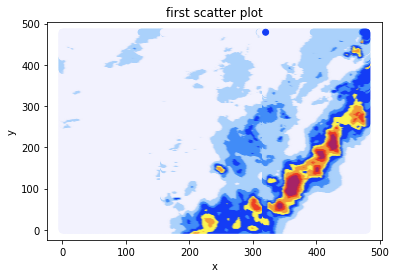

In [253]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

ax.scatter(points[0], points[1], c=points[2])

ax.set_title('first scatter plot')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.show()

# スカラ→観測点数
$$ n_i = \frac{nI(d_i)}{\sum_{i=1}^{n} d_i} $$

In [10]:
from tqdm import tqdm

def scalar2observation(rainfall):
    grid_size = 160
    n = grid_size**2 # 観測地点数
    observation_num_list = [] # 観測点数を格納するリスト
    sum_di = int(sum(rainfall))
    # n_iの最大値は16ぽい...

    for i, val in enumerate(rainfall):
        for k in range(int(n*val / sum_di)):
            observation_num_list.append([(i+1) % grid_size, int(i / grid_size)])
    return observation_num_list

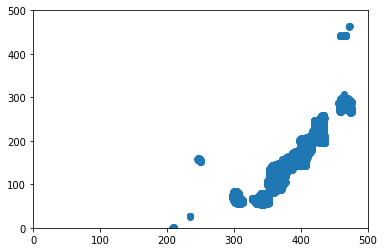

In [229]:
import matplotlib.pyplot as plt

# observation_num_list = scalar2observation(rainfall_np)
X = [x[0] for x in observation_num_list]
Y = [x[1] for x in observation_num_list]
plt.scatter(X, Y)
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()

In [180]:
observation_num_tup = tuple([tuple(x) for x in observation_num_list])

In [181]:
s_list = list(set(observation_num_tup))

In [23]:
observation_num_tup.count(s_list[0])

2

In [182]:
points_count = []
for s in s_list:
    points_count.append(list(s) + [observation_num_tup.count(s)])

# クラスタリング

In [193]:
from sklearn.cluster import KMeans

pred = KMeans(n_clusters=5).fit_predict(observation_num_list)

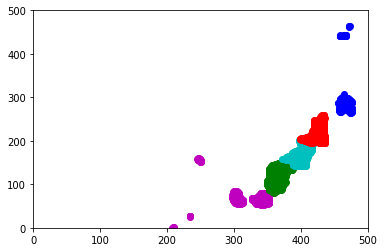

In [224]:
color_dict = {0: 'r', 1: 'g', 2: 'b', 3: 'c', 4:'m'}

for i in range(len(pred)):
    plt.scatter(observation_num_list[i][0], observation_num_list[i][1], c=color_dict[pred[i]])
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()

/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


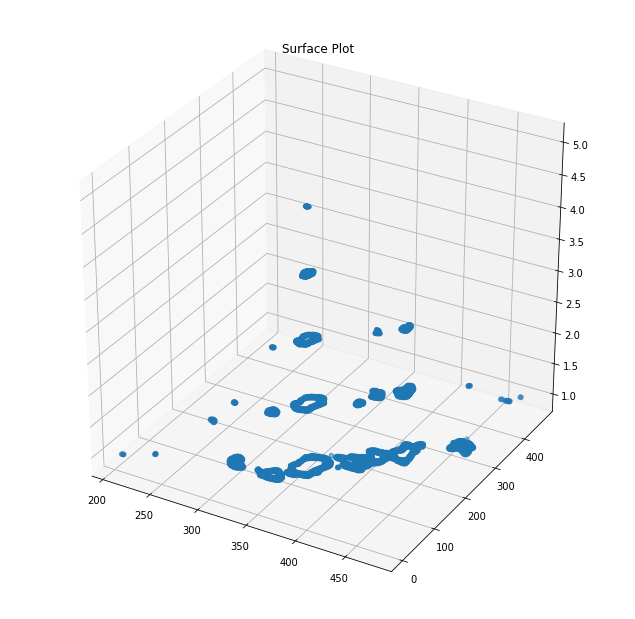

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# (x,y)データを作成
x = [x[0] for x in points_count]
y = [x[1] for x in points_count]
z = [x[2] for x in points_count]

# 格子点を作成
X, Y = np.meshgrid(x, y)
Z = np.meshgrid(z)


fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(x, y, z)
ax.set_title("Surface Plot")
fig.show()

## GMM

In [186]:
from sklearn import preprocessing, mixture

def scale(X):
    """データ行列Xを属性ごとに標準化したデータを返す"""
    # 属性の数（=列の数）
    col = X.shape[1]

    # 属性ごとに平均値と標準偏差を計算
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)

    # 属性ごとデータを標準化
    for i in range(col):
        X[:,i] = (X[:,i] - mu[i]) / sigma[i]

    return X

In [230]:
X = [x[0] for x in observation_num_list]
Y = [x[1] for x in observation_num_list]
score = []

for i in range(1, 100):
    gmm=mixture.GaussianMixture(n_components=i,covariance_type='full')
    z_gmm=gmm.fit(observation_num_list)
    z_gmm=z_gmm.predict(observation_num_list)
    
    # print("k:{}".format(i), "aic:{}".format(gmm.aic(np.array(observation_num_list))), "bic:{}".format(gmm.bic(np.array(observation_num_list))))
    # print("ave:{}".format((gmm.aic(np.array(observation_num_list)) + gmm.bic(np.array(observation_num_list)))/2))
    score.append((gmm.aic(np.array(observation_num_list)) + gmm.bic(np.array(observation_num_list)))/2)
    
"""
plt.figure(figsize=(10, 10))
plt.scatter(X, Y, c=z_gmm)
plt.xlim([0,500])
plt.ylim([0,500])
plt.show
"""

'\nplt.figure(figsize=(10, 10))\nplt.scatter(X, Y, c=z_gmm)\nplt.xlim([0,500])\nplt.ylim([0,500])\nplt.show\n'

In [237]:
gmm=mixture.GaussianMixture(n_components=5,covariance_type='full')
z_gmm=gmm.fit(observation_num_list)
z_gmm=z_gmm.predict(observation_num_list)

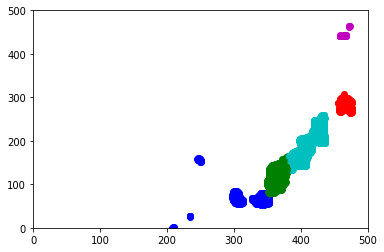

In [238]:
color_dict = {0: 'r', 1: 'g', 2: 'b', 3: 'c', 4:'m'}

for i in range(len(z_gmm)):
    plt.scatter(observation_num_list[i][0], observation_num_list[i][1], c=color_dict[z_gmm[i]])
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()

In [233]:
score.index(min(score))

29

<Container object of 99 artists>

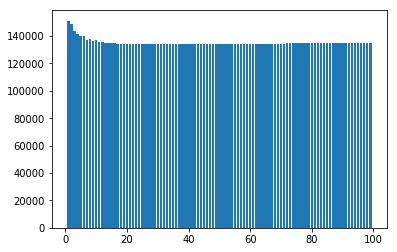

In [231]:
plt.bar(np.array(range(1,100)), np.array(score))

In [232]:
print(gmm.aic(np.array(observation_num_list)), gmm.bic(np.array(observation_num_list)))

133139.47871226643 137261.45217706362


In [ ]:
X_train = scale(np.array(observation_num_list))

In [ ]:
n_components = 5
gmm = sklearn.mixture.GaussianMixture(n_components, covariance_type='full')
gmm.fit(X_train)